In this notebook we want to analyze the components of the function `detect_text_blocks`. Hence we go line by line of the function to understand how it works and how it can be improved. We do this since we believe this is a core function of the module and understanding it and improving it is a necessary step to build a better OCR engine.

In [1]:
import cv2
from PIL import Image
from IPython.display import display

For convenience we define the following function that allows us to show `cv2` images.

In [2]:
def show_cv2_img(cv2_img):
    """
    Transforms a cv2 image into a PIL image
    """

    return Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))

In [3]:
def show_multiple_cv2_imgs (list_cv2_imgs):

    """
    Transforms multiple cv2 Images into PIL images and shows them
    """

    list_PIL_imgs = []

    for img in list_cv2_imgs:
        list_PIL_imgs.append(show_cv2_img(img))

    return display(*list_PIL_imgs)

So let's start.
We first read the image with a gray scale which will allow us to threshold it.

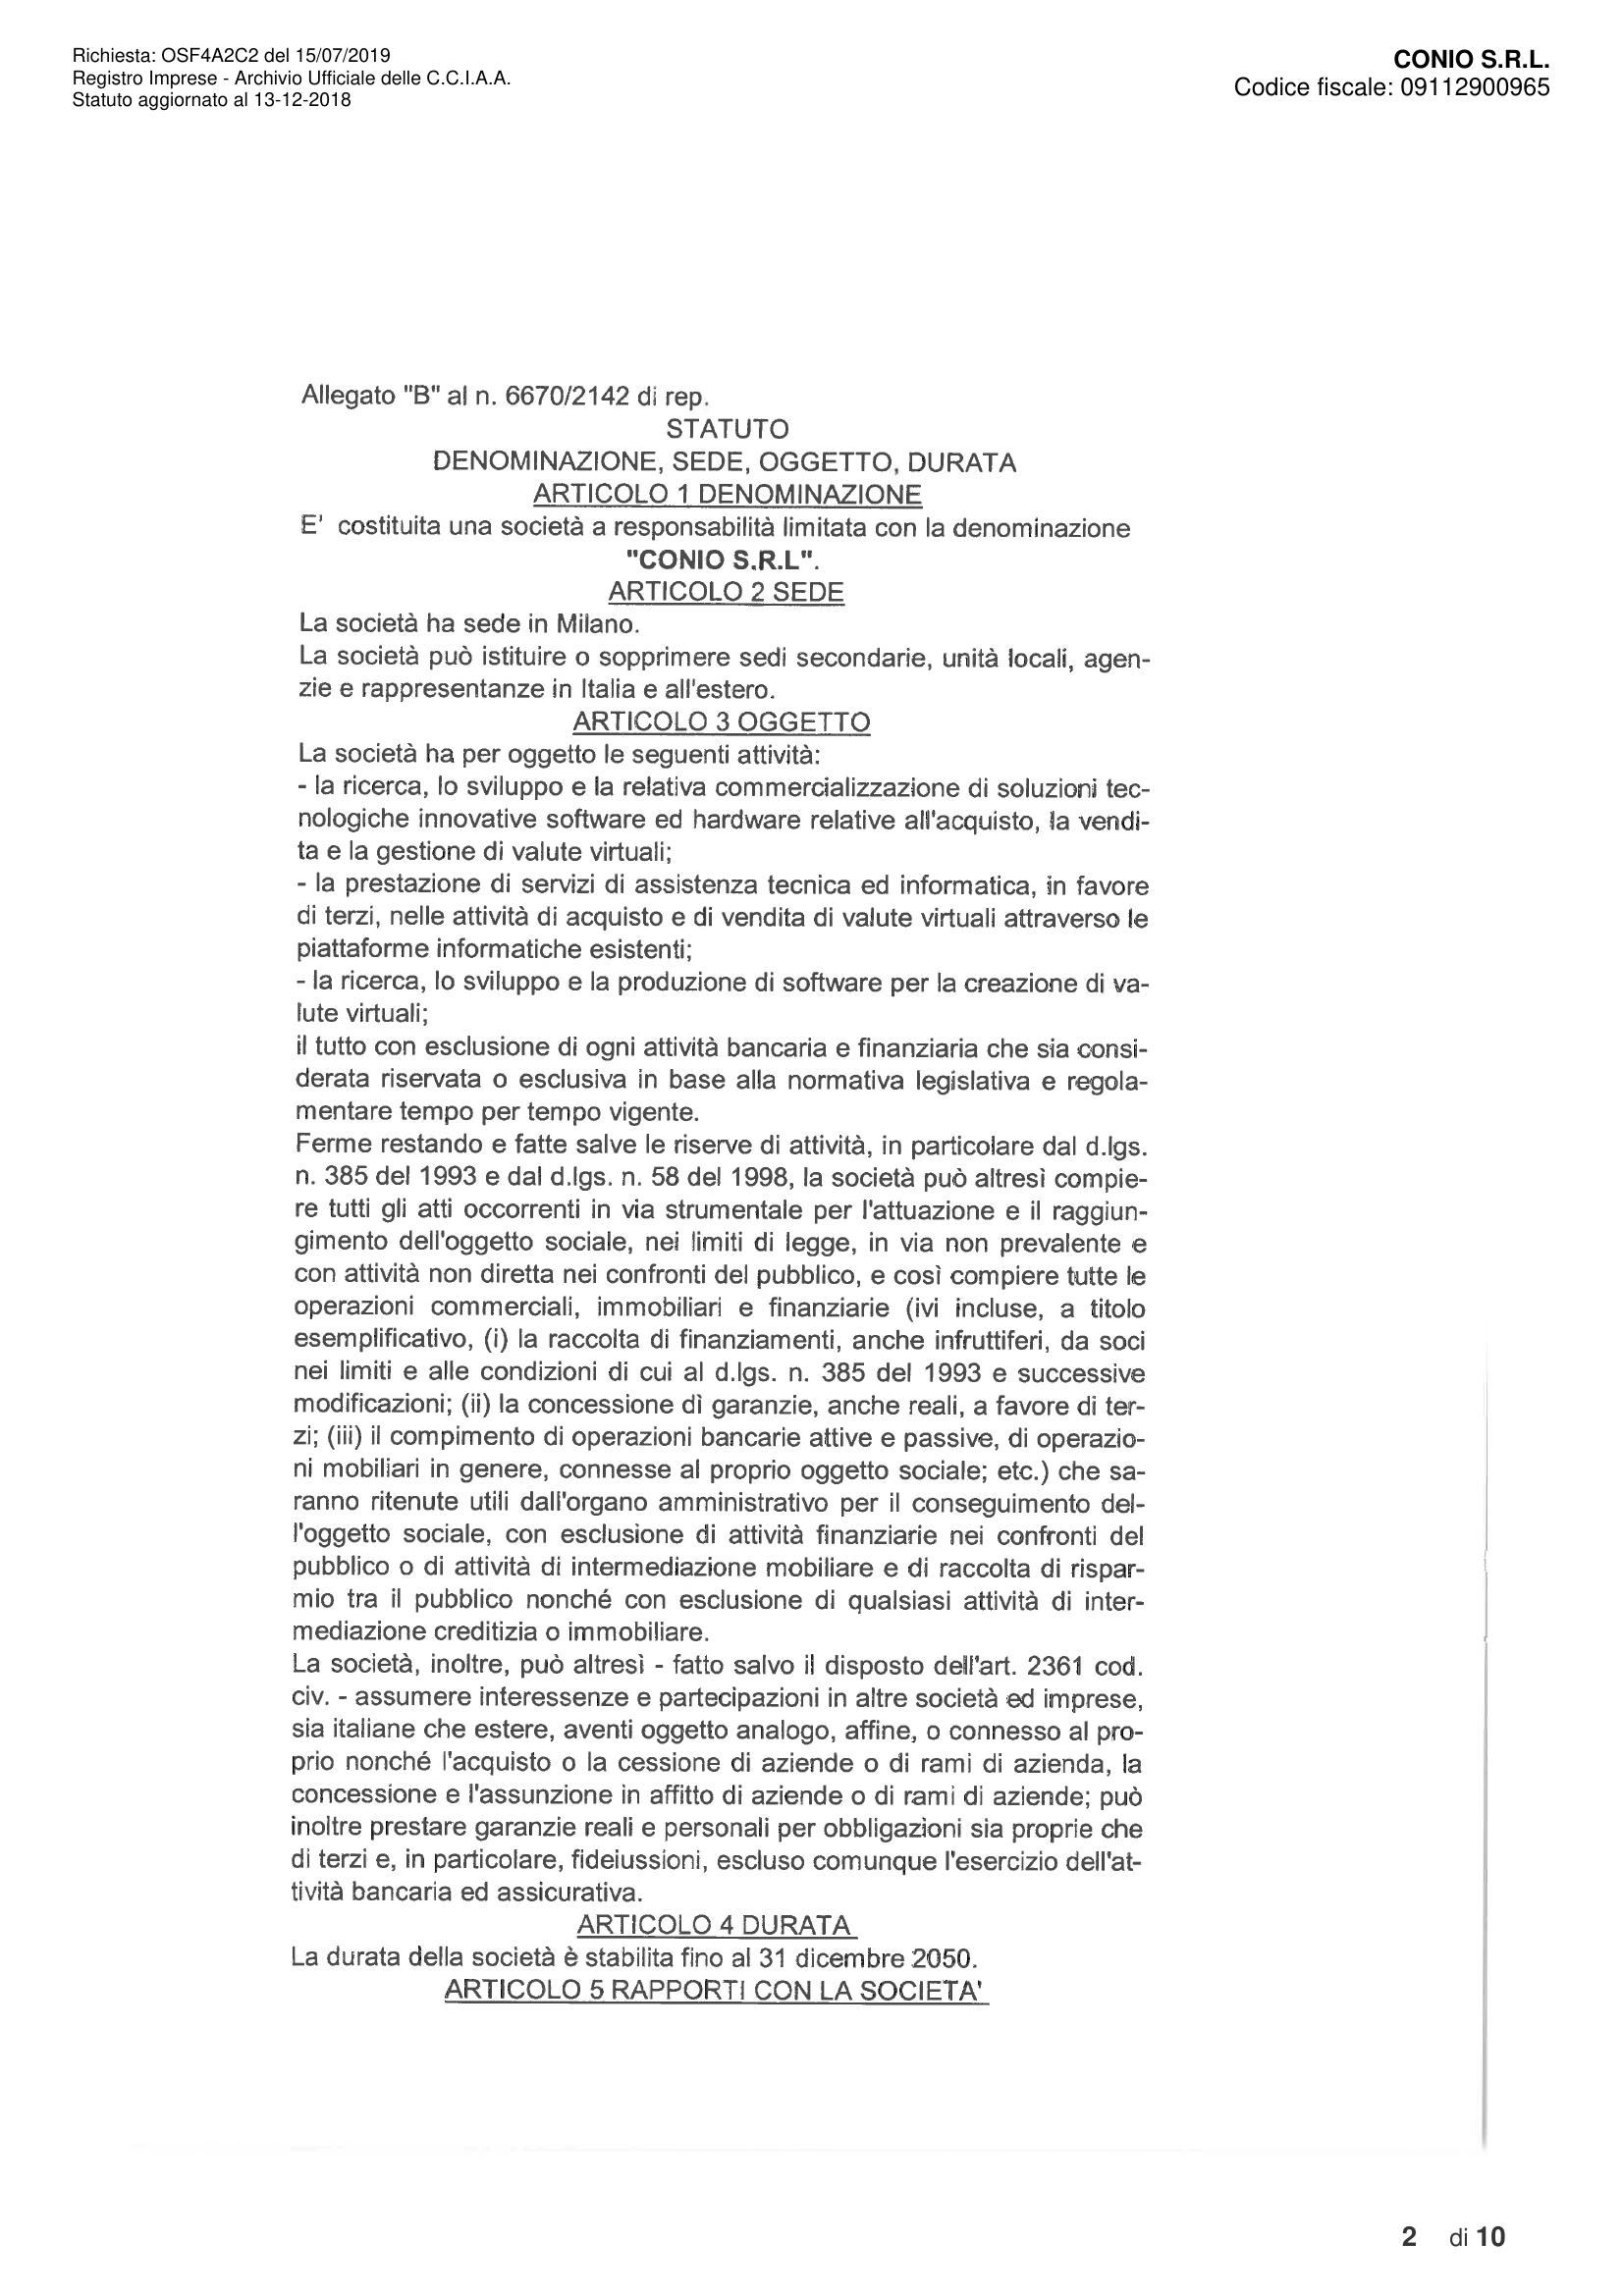

In [94]:
gray_img = cv2.imread('test_data/page_1.jpg', cv2.IMREAD_GRAYSCALE)
show_cv2_img(gray_img)

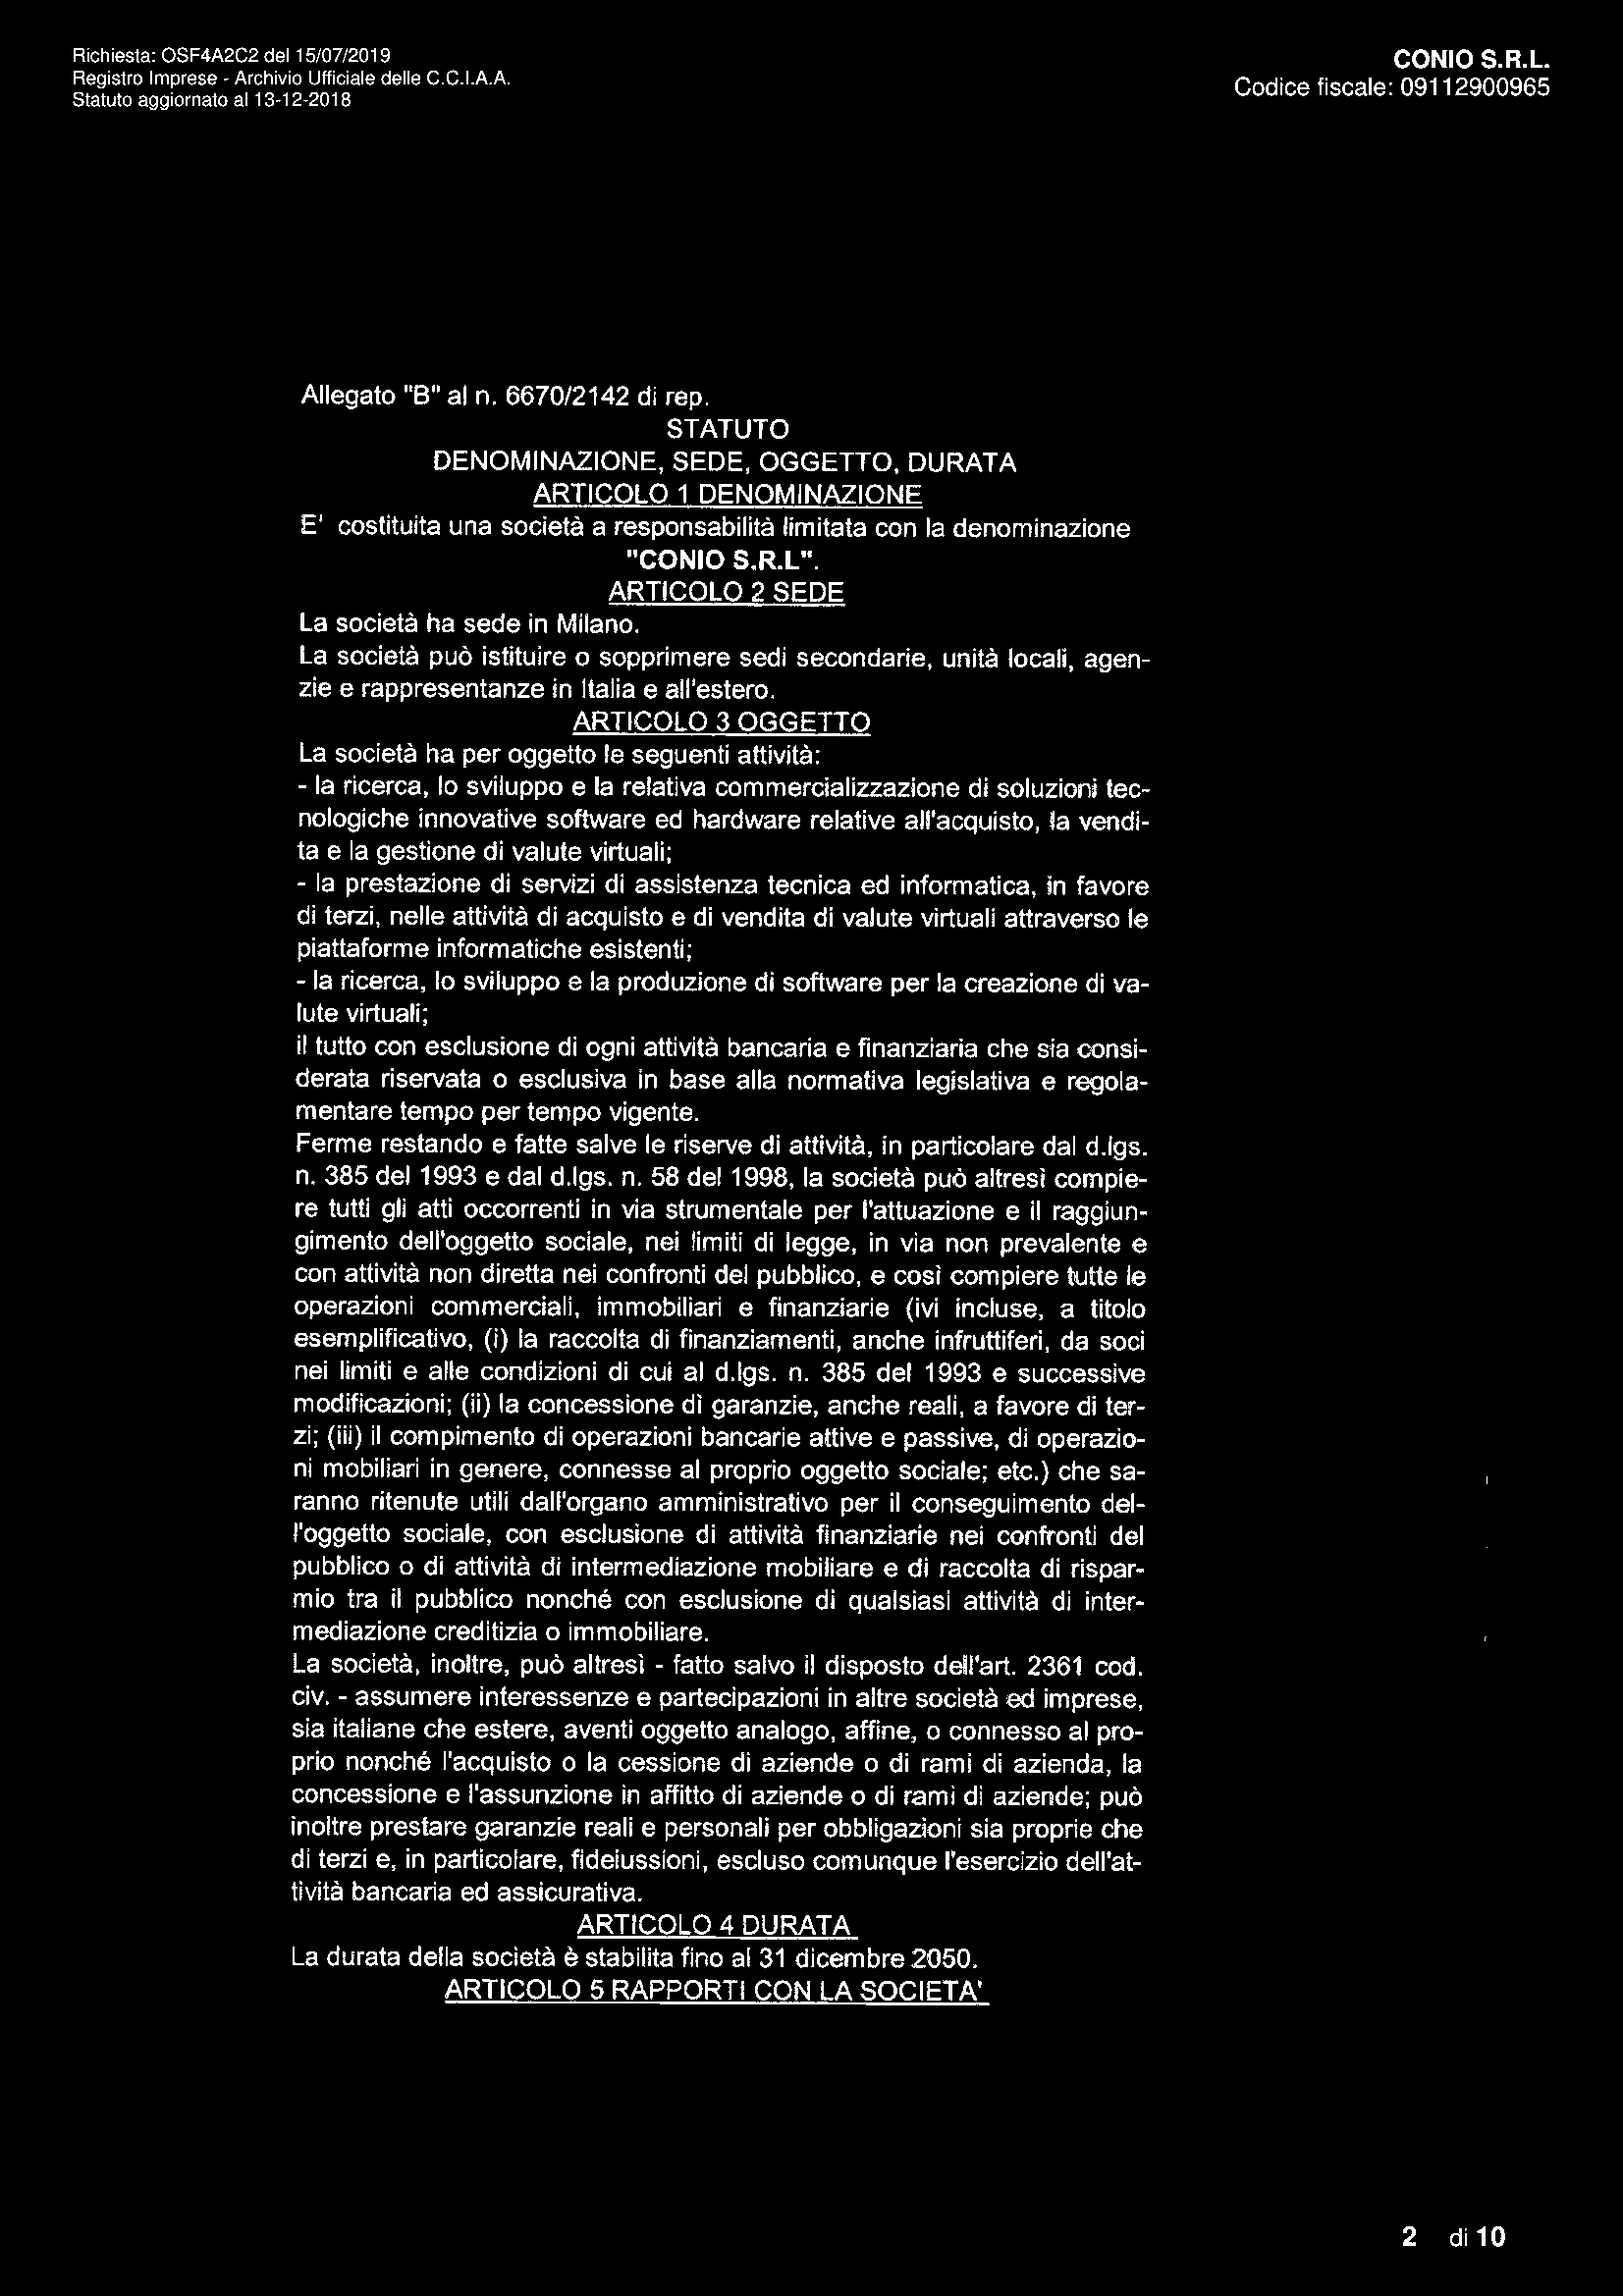

In [87]:
thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
show_cv2_img(thresh)

We would like to apply some transformations on our document image. In particular we want to dilate the text so that neighboring letters all dilate to form a white box, as shown in the image below:


![](pics/p0.png)

We can use different kernels to perform such transformations, for example here the result of using a $33 \times 33$ ellipse for the dilation:

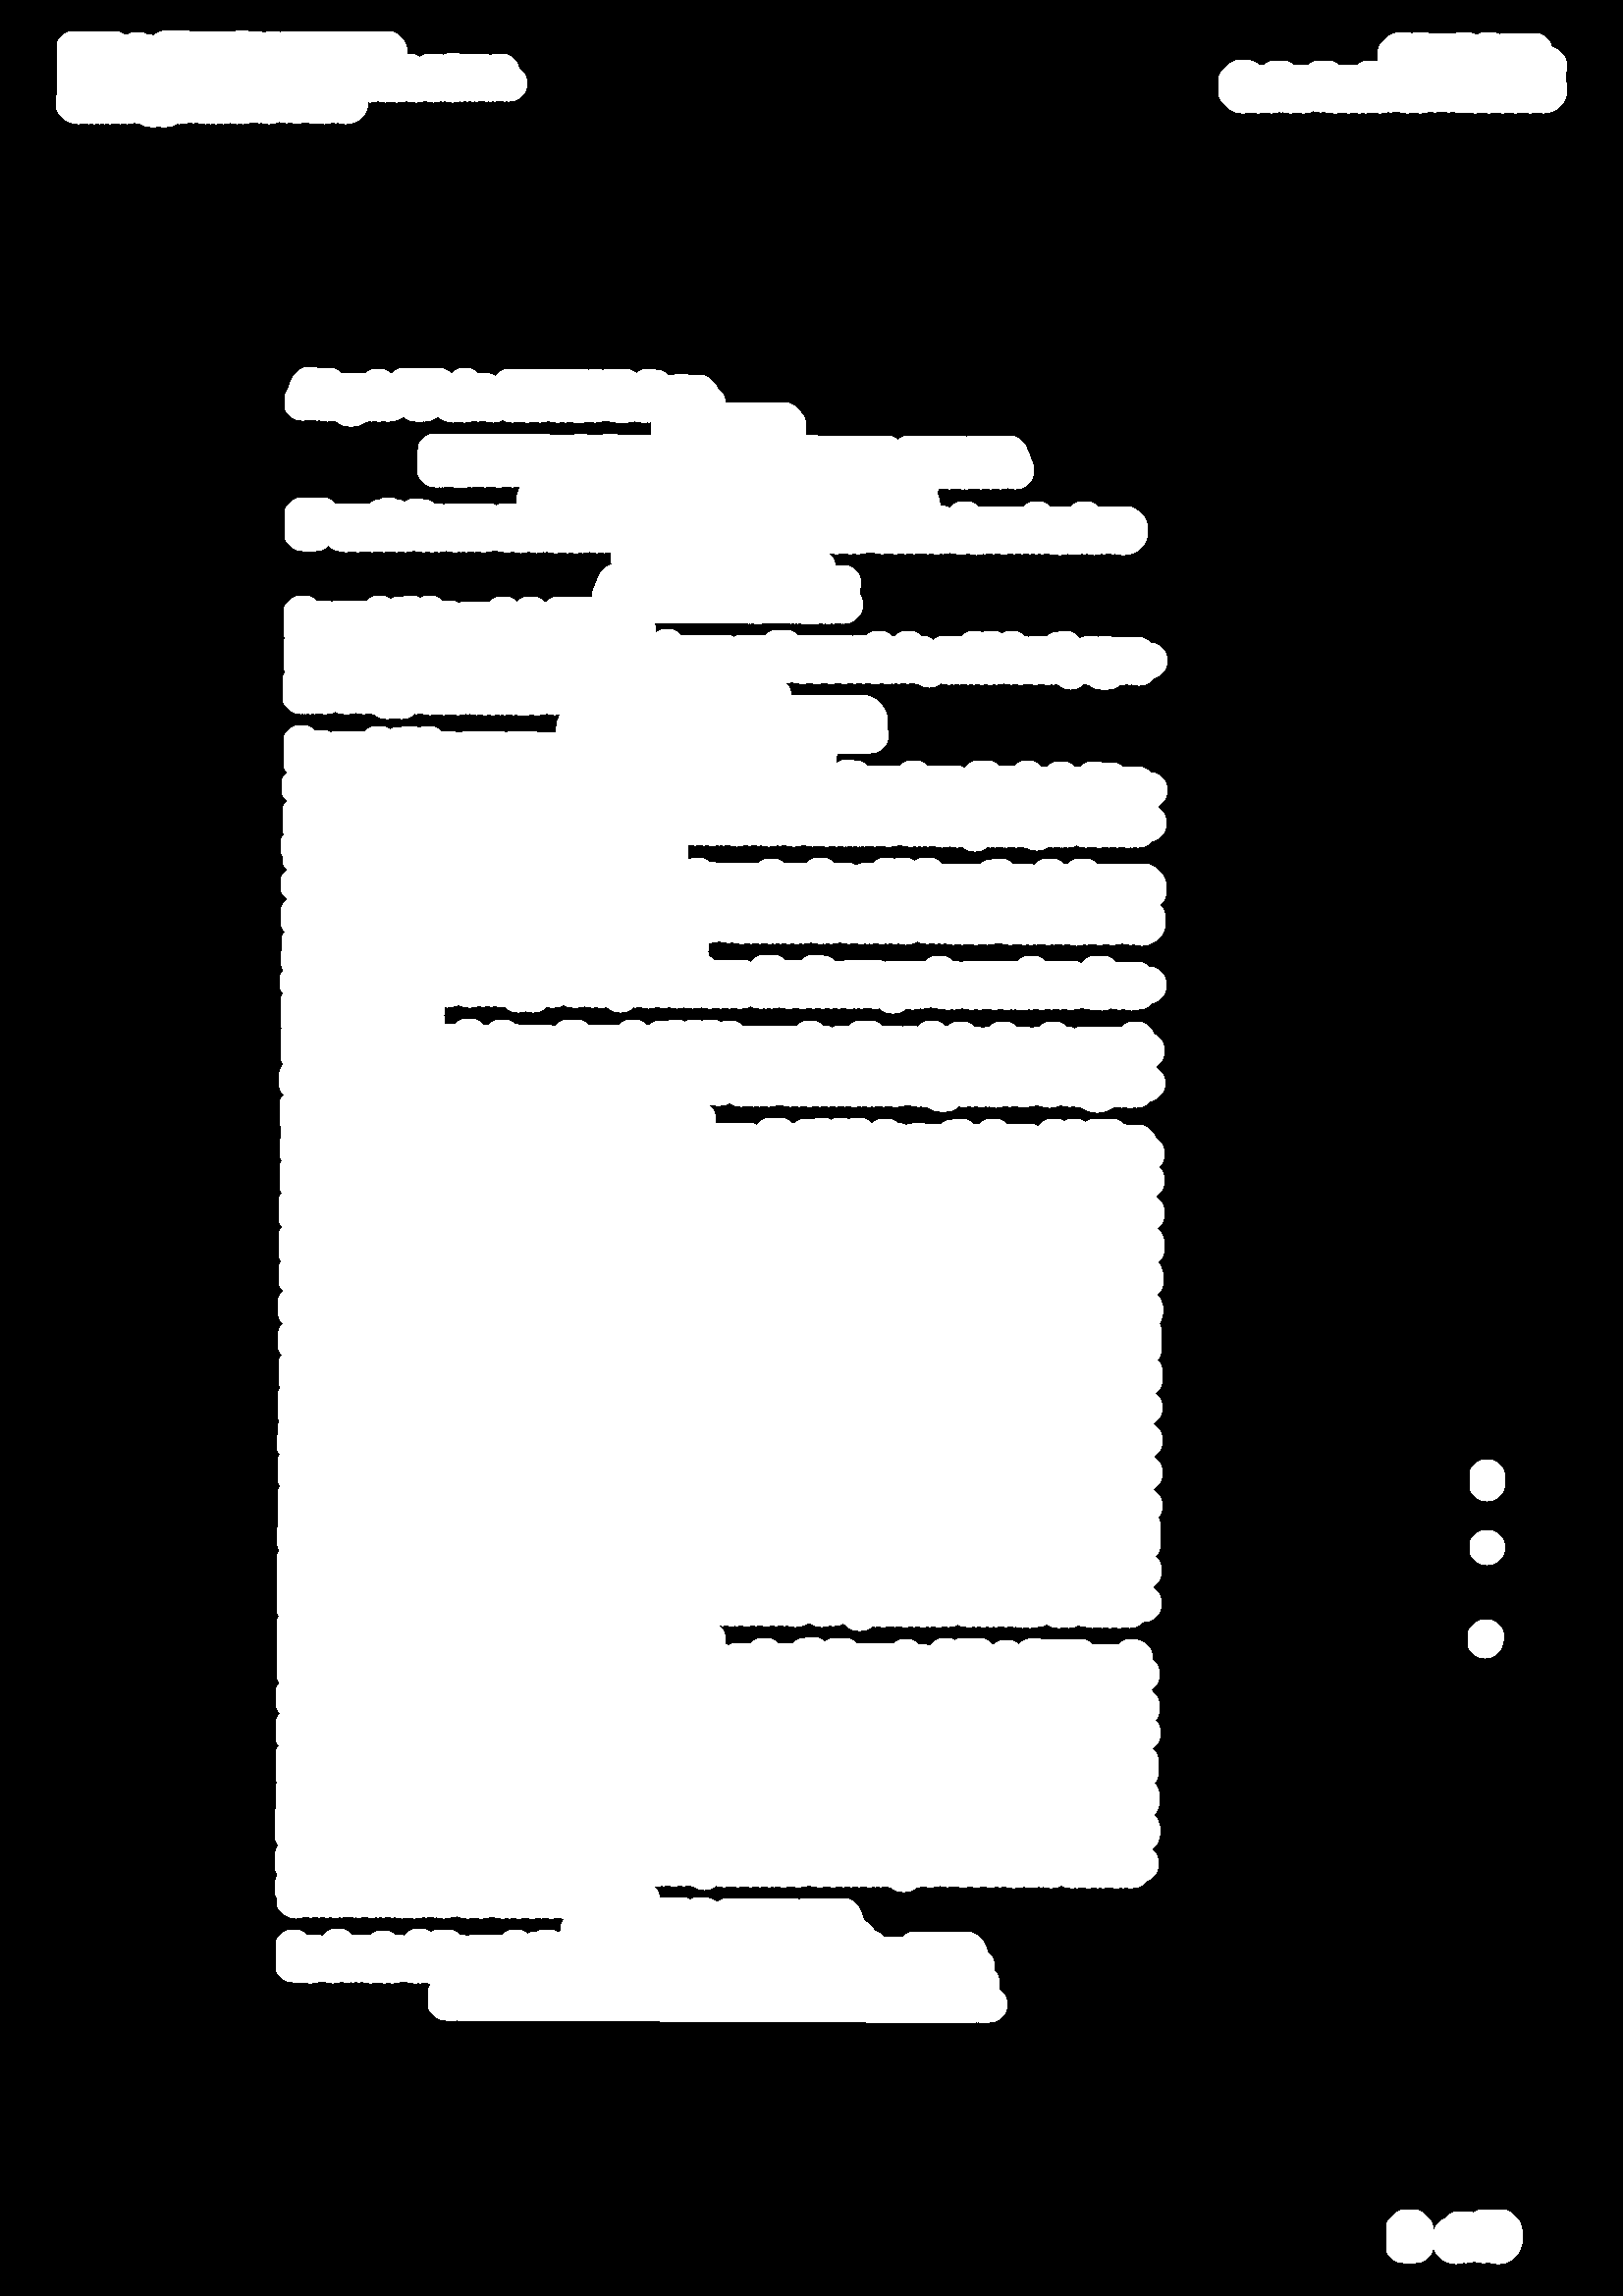

In [88]:
elliptical_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (36, 36))


dilated_image = cv2.dilate(thresh, elliptical_kernel, iterations = 1)
show_cv2_img(dilated_image)

The size and shape of the kernel are all hyperparameters that can be tuned for the particular problem you need to solve.
In our case we chose a $16 \times 96$ rectangular kernel (for no particular reasone except some trial and error).

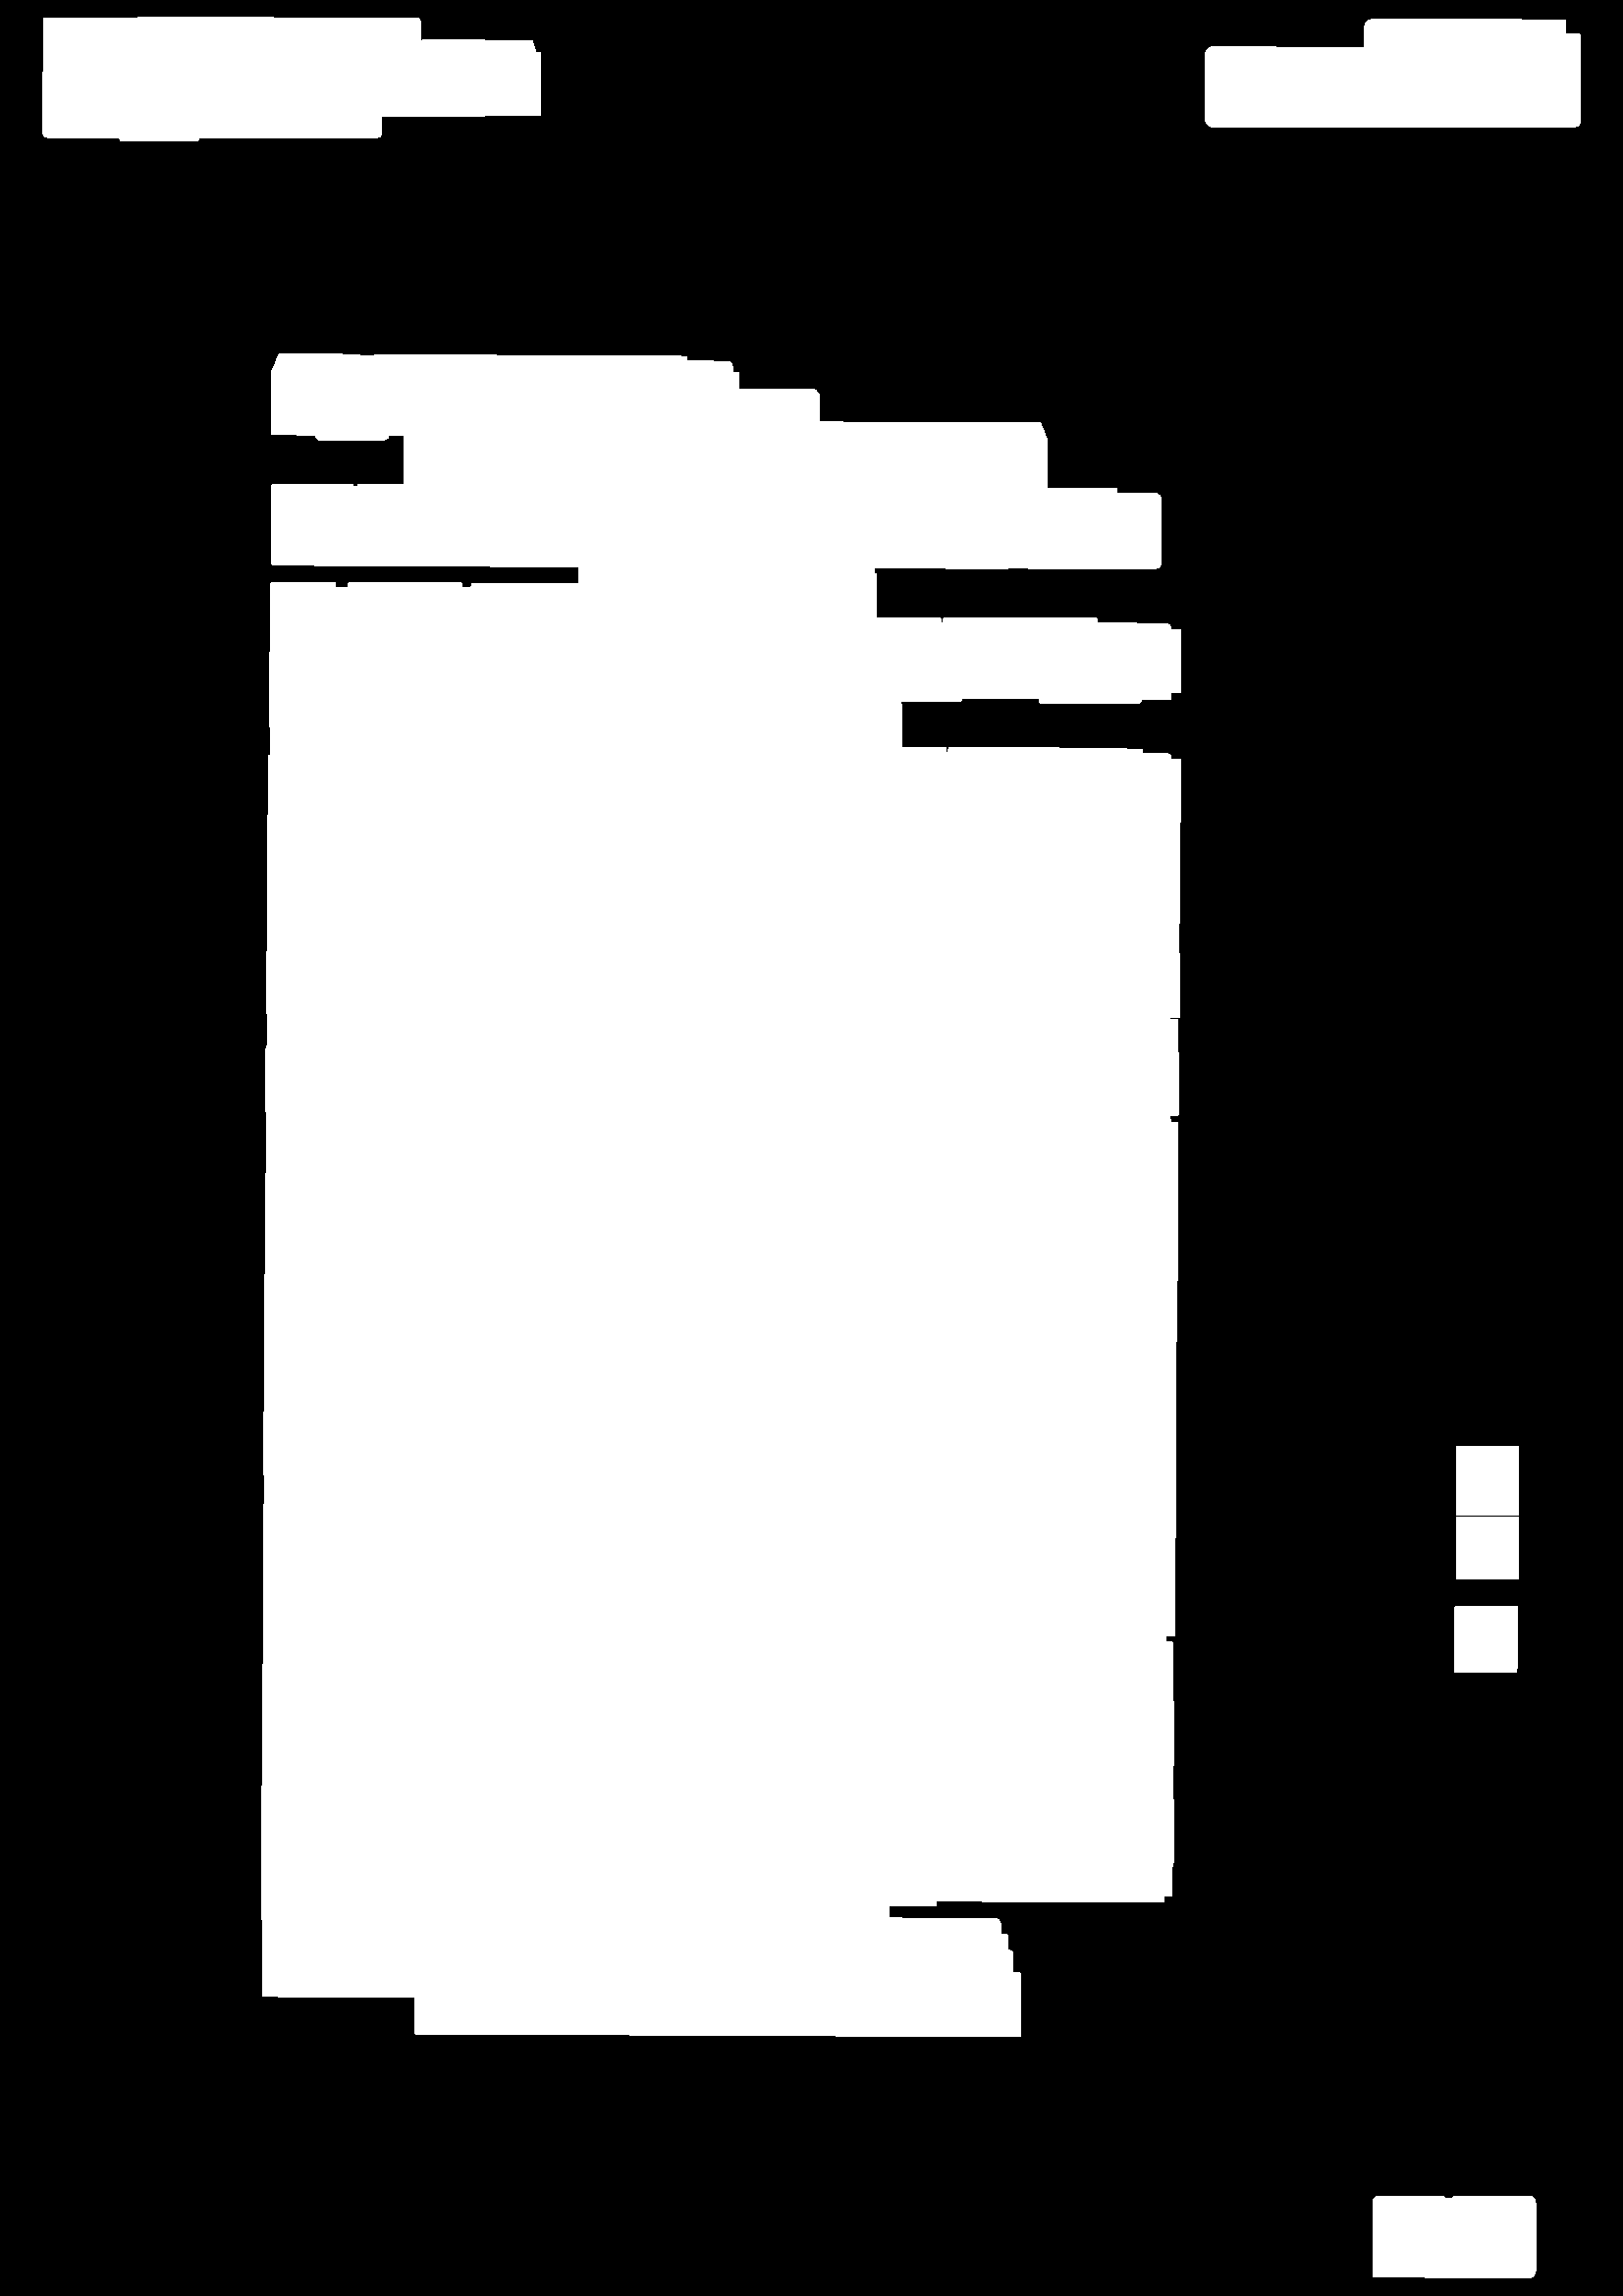

In [89]:
rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (64, 64))


dilated_image = cv2.dilate(thresh, rectangular_kernel, iterations = 1)
show_cv2_img(dilated_image)

Let's now find the contours of the text boxes using the dilated image:

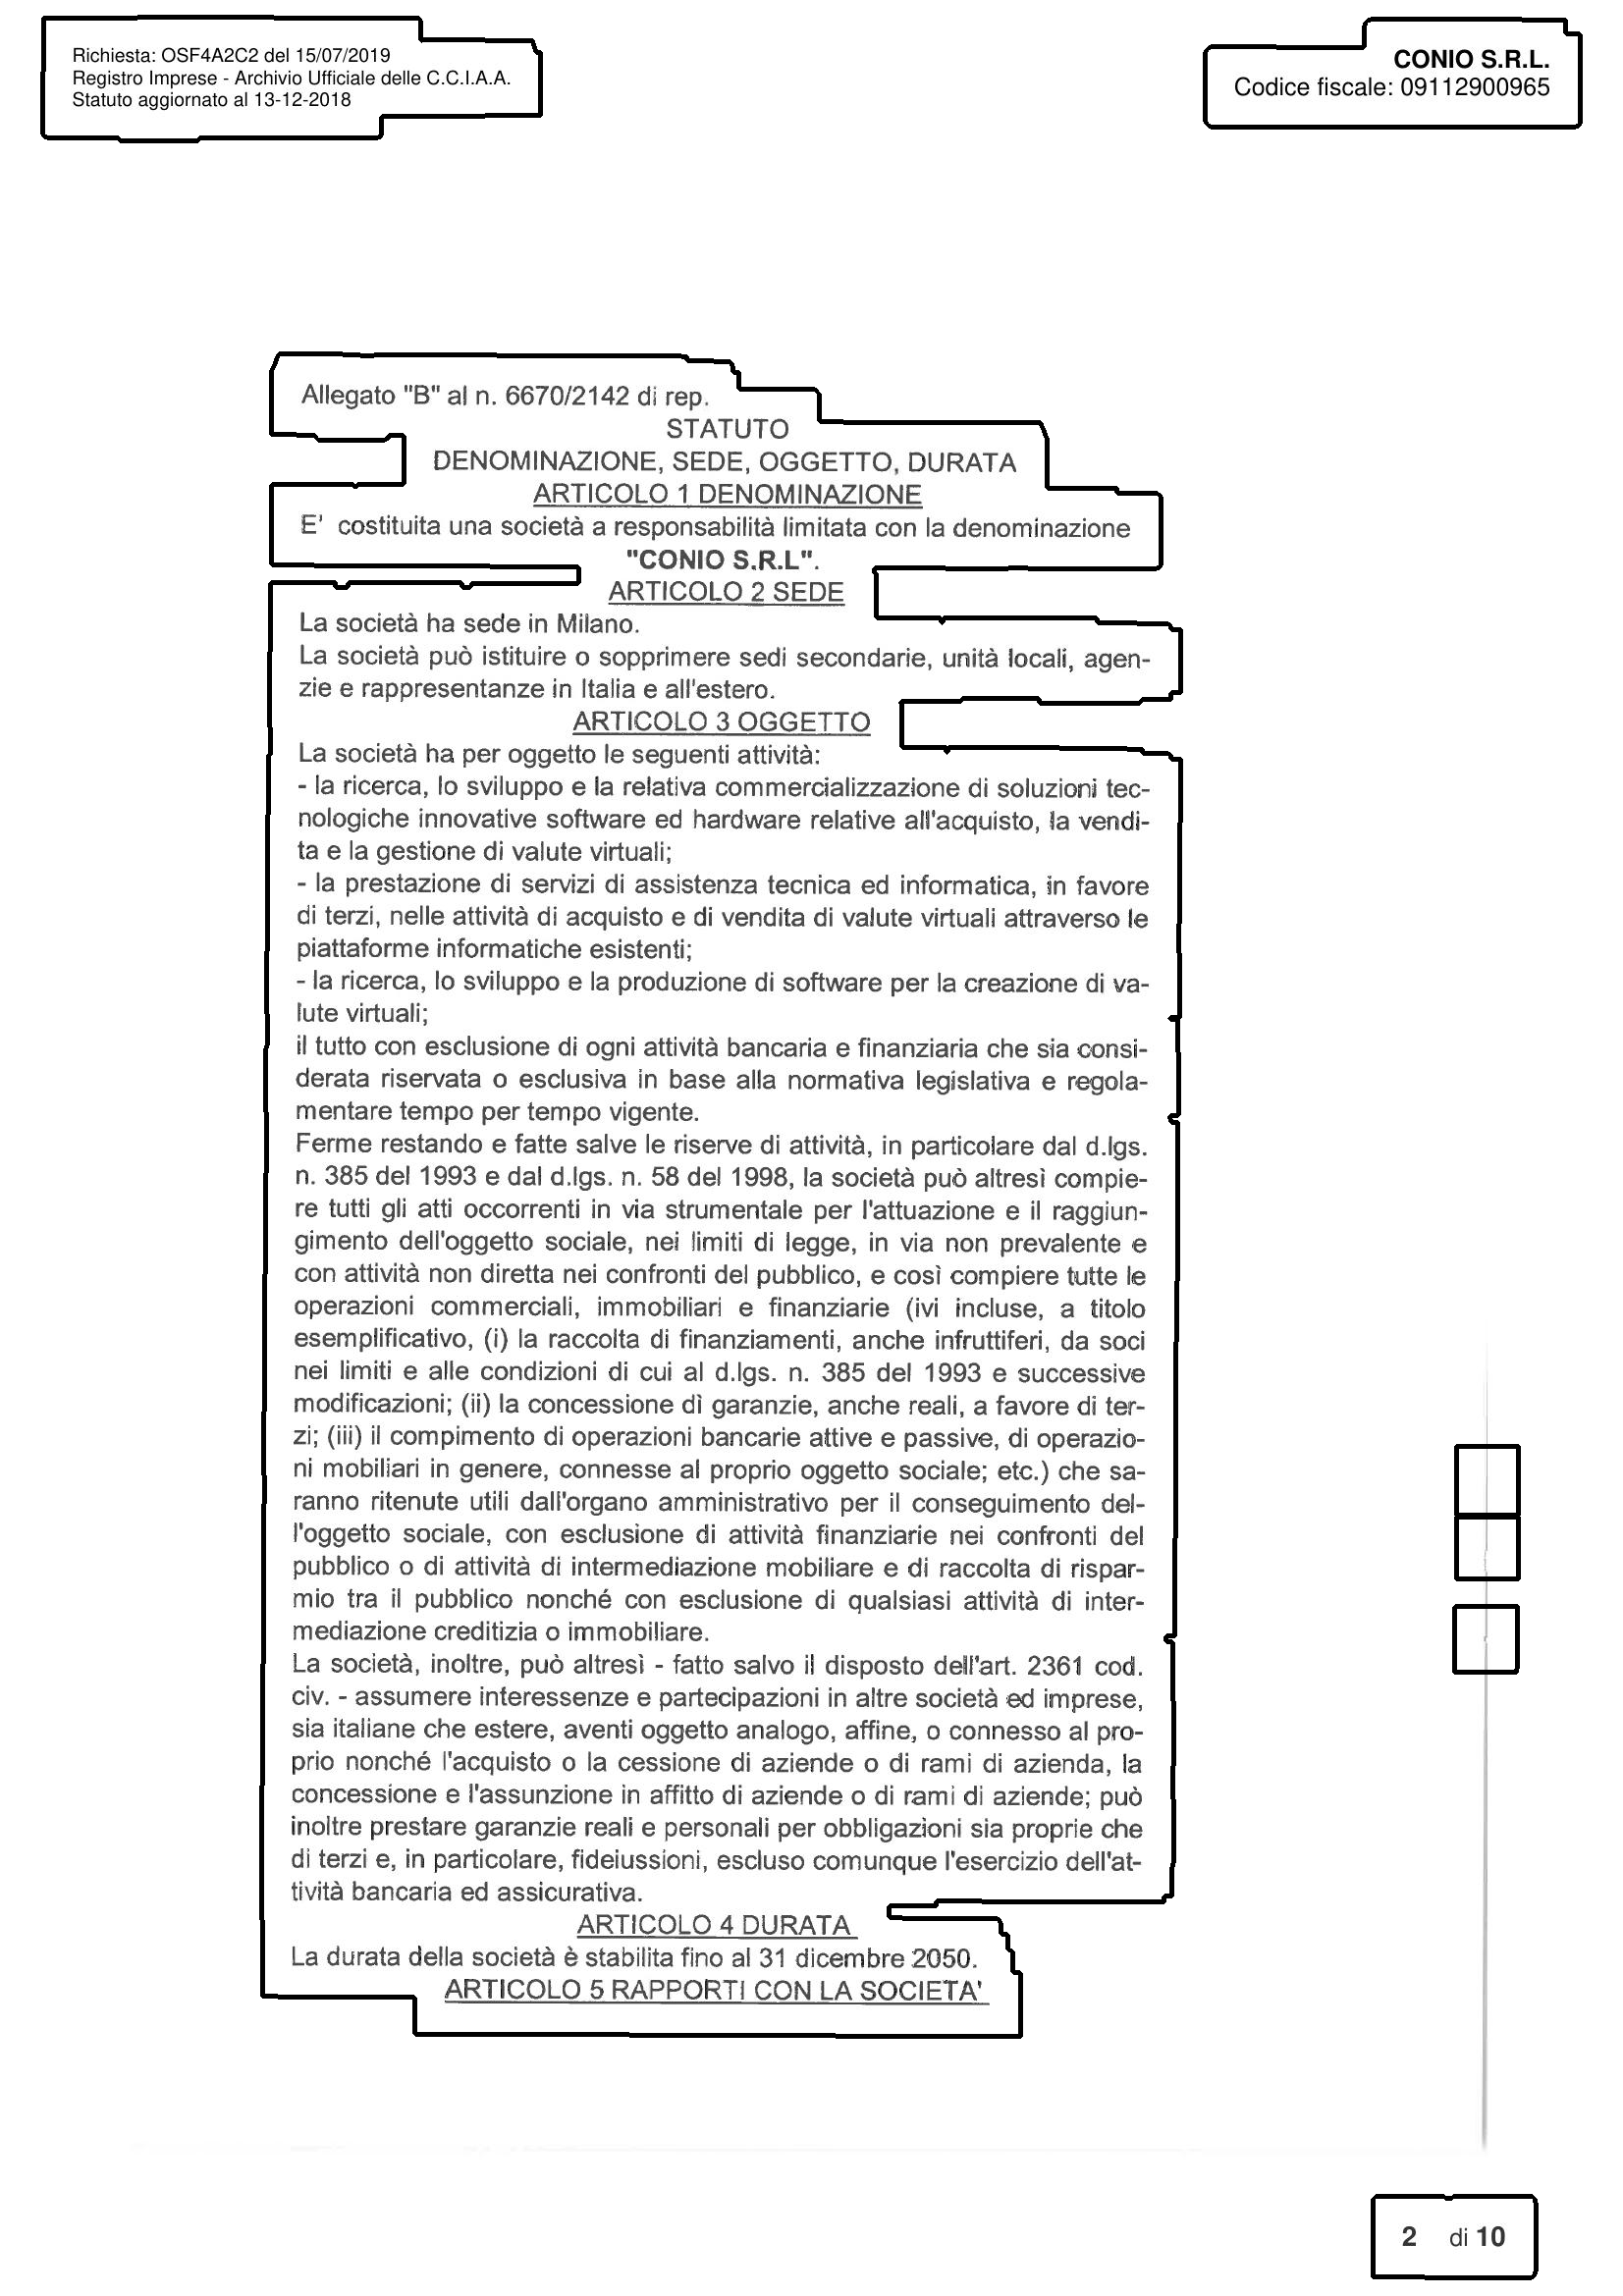

In [90]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
test = gray_img.copy()
cv2.drawContours(test, contours, -1, (0,255,0), 3)

show_cv2_img(test)

Finally given these contours we want to draw rectangles around the text blocks they found so that we can then pass the regions they detect to `pytesseract`:

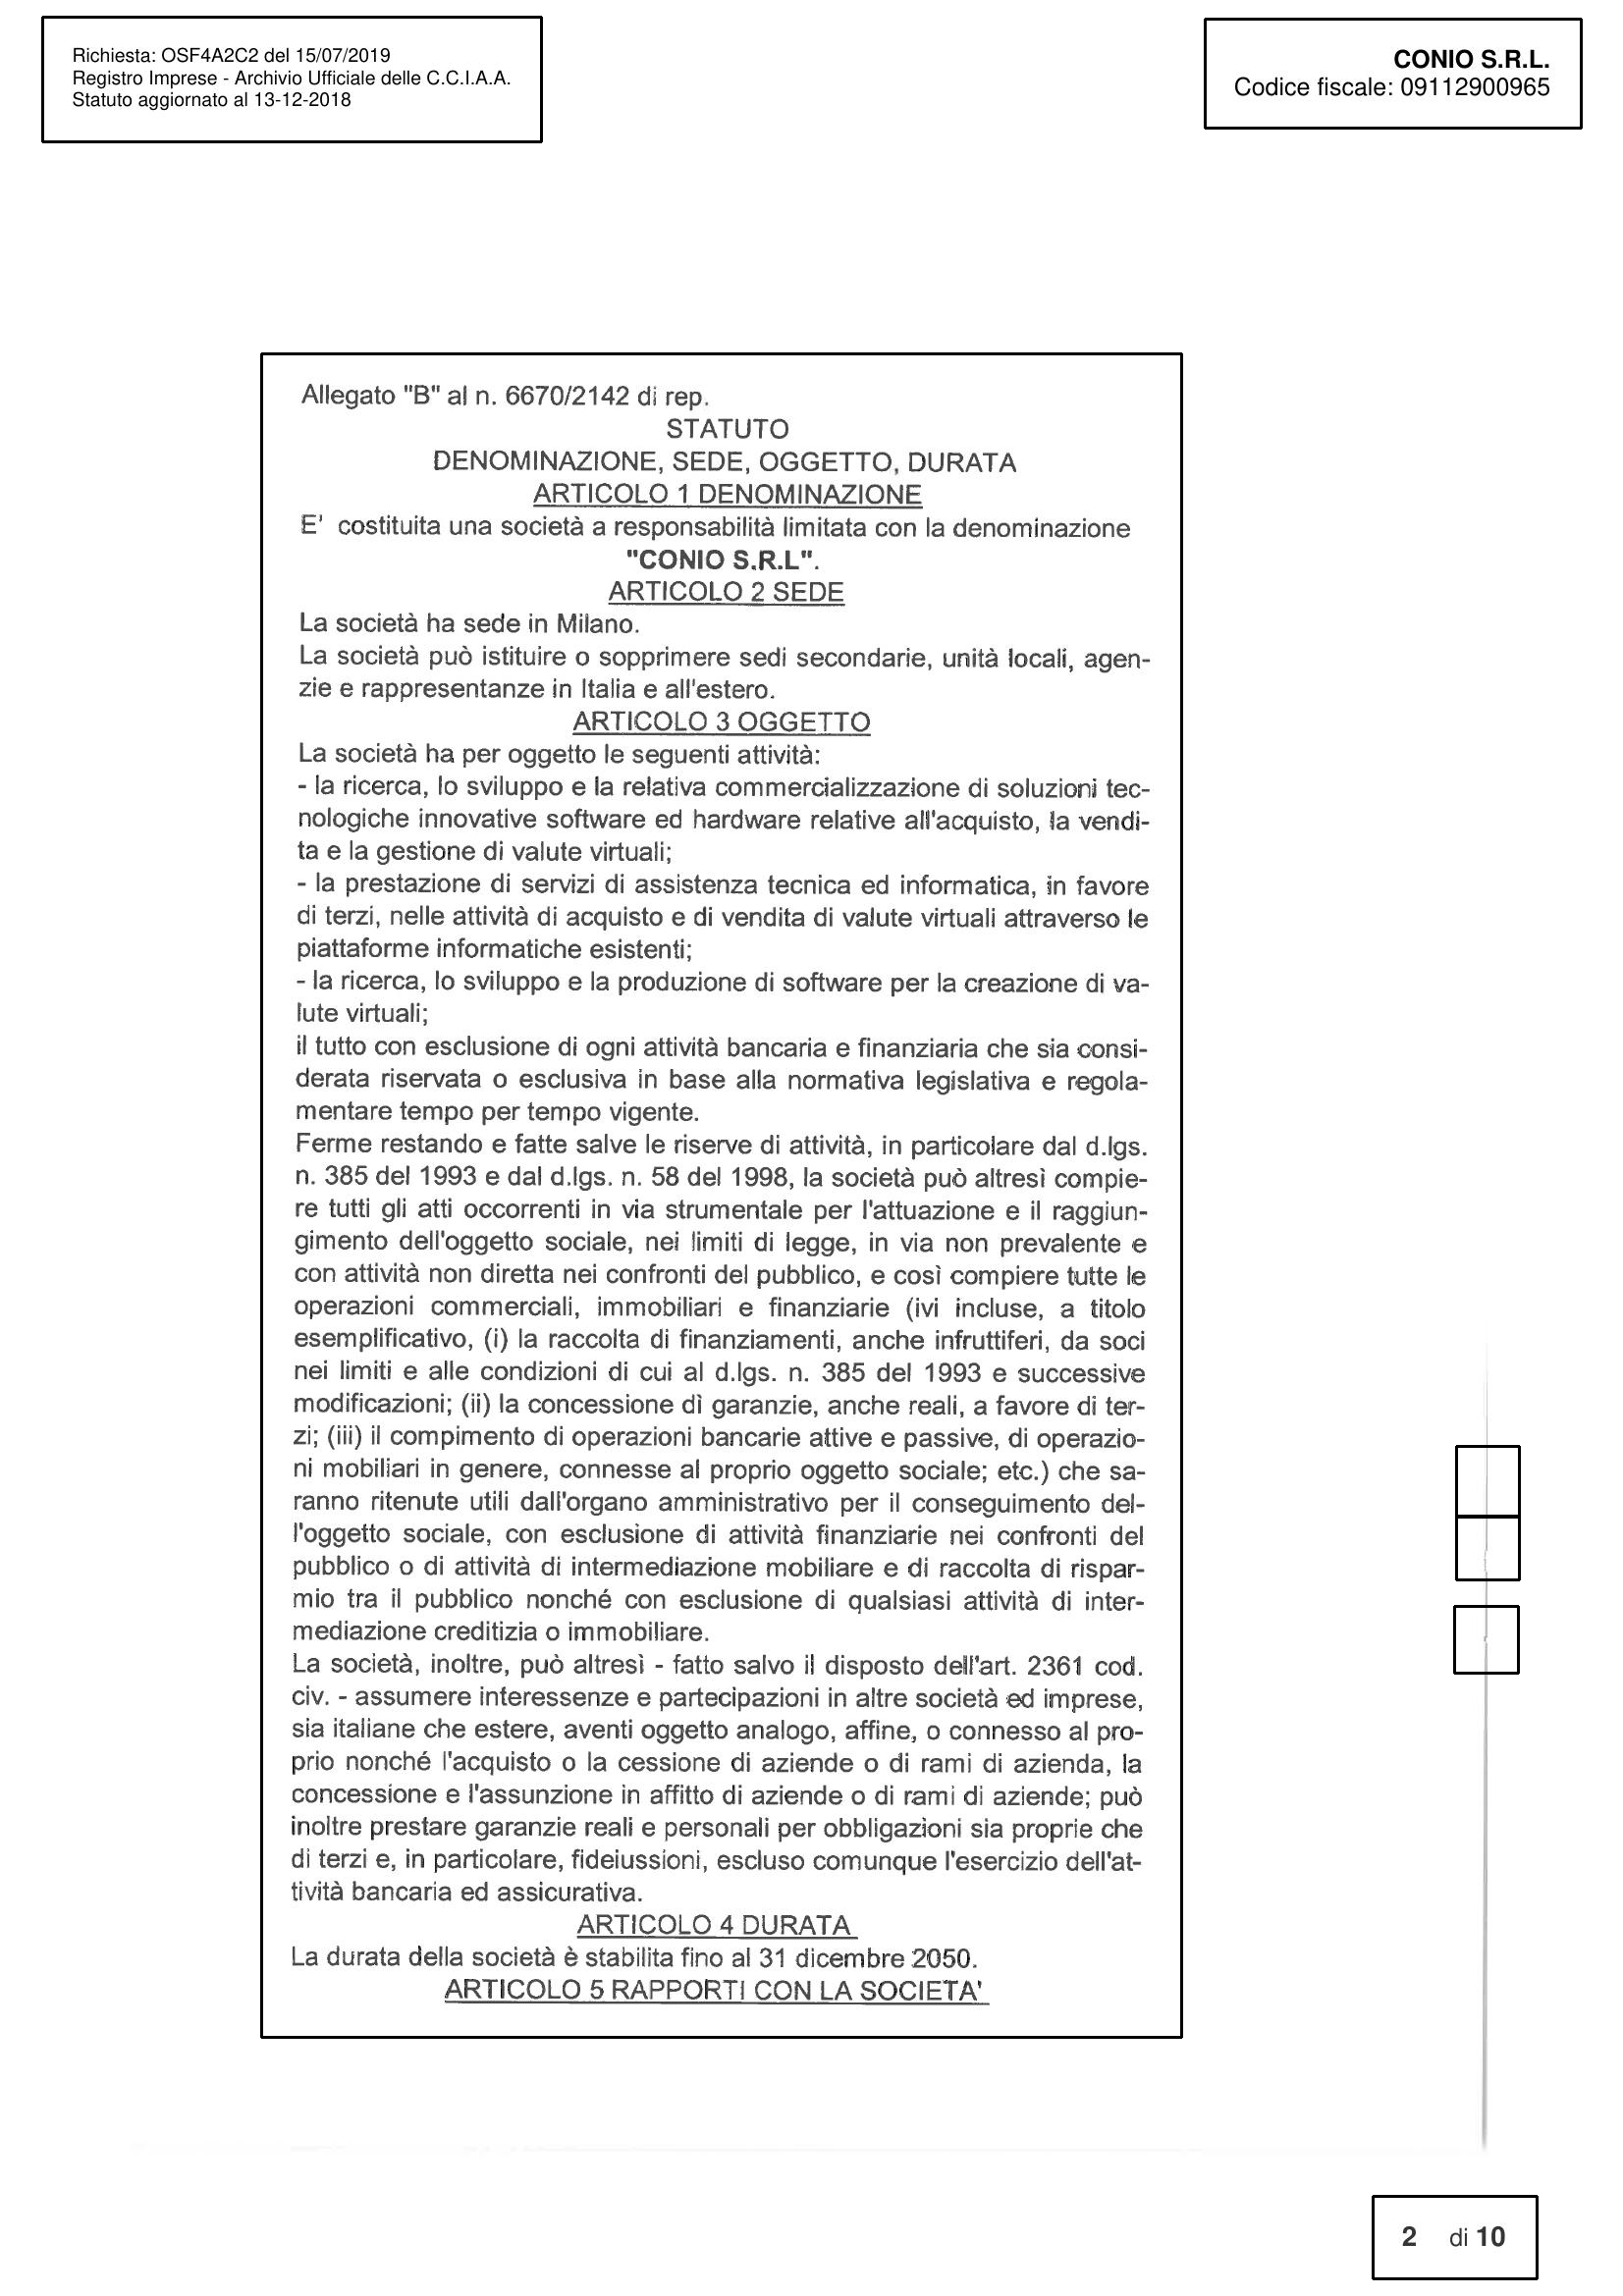

In [91]:
result = gray_img.copy()
roi_regions = []

for c in contours:
    # here we get the rectangle that best fit the contour coordinates
    x, y, w, h = cv2.boundingRect(c)

    # store the regions with blocks of text
    roi_regions.append(result[y:y+h, x:x+w])

    # draw on the image the black rectangle found above
    cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)


show_cv2_img(result)

Finally we want to extract the regions of texts that we will then feed to `pytesseract`:

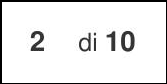

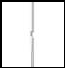

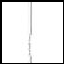

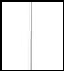

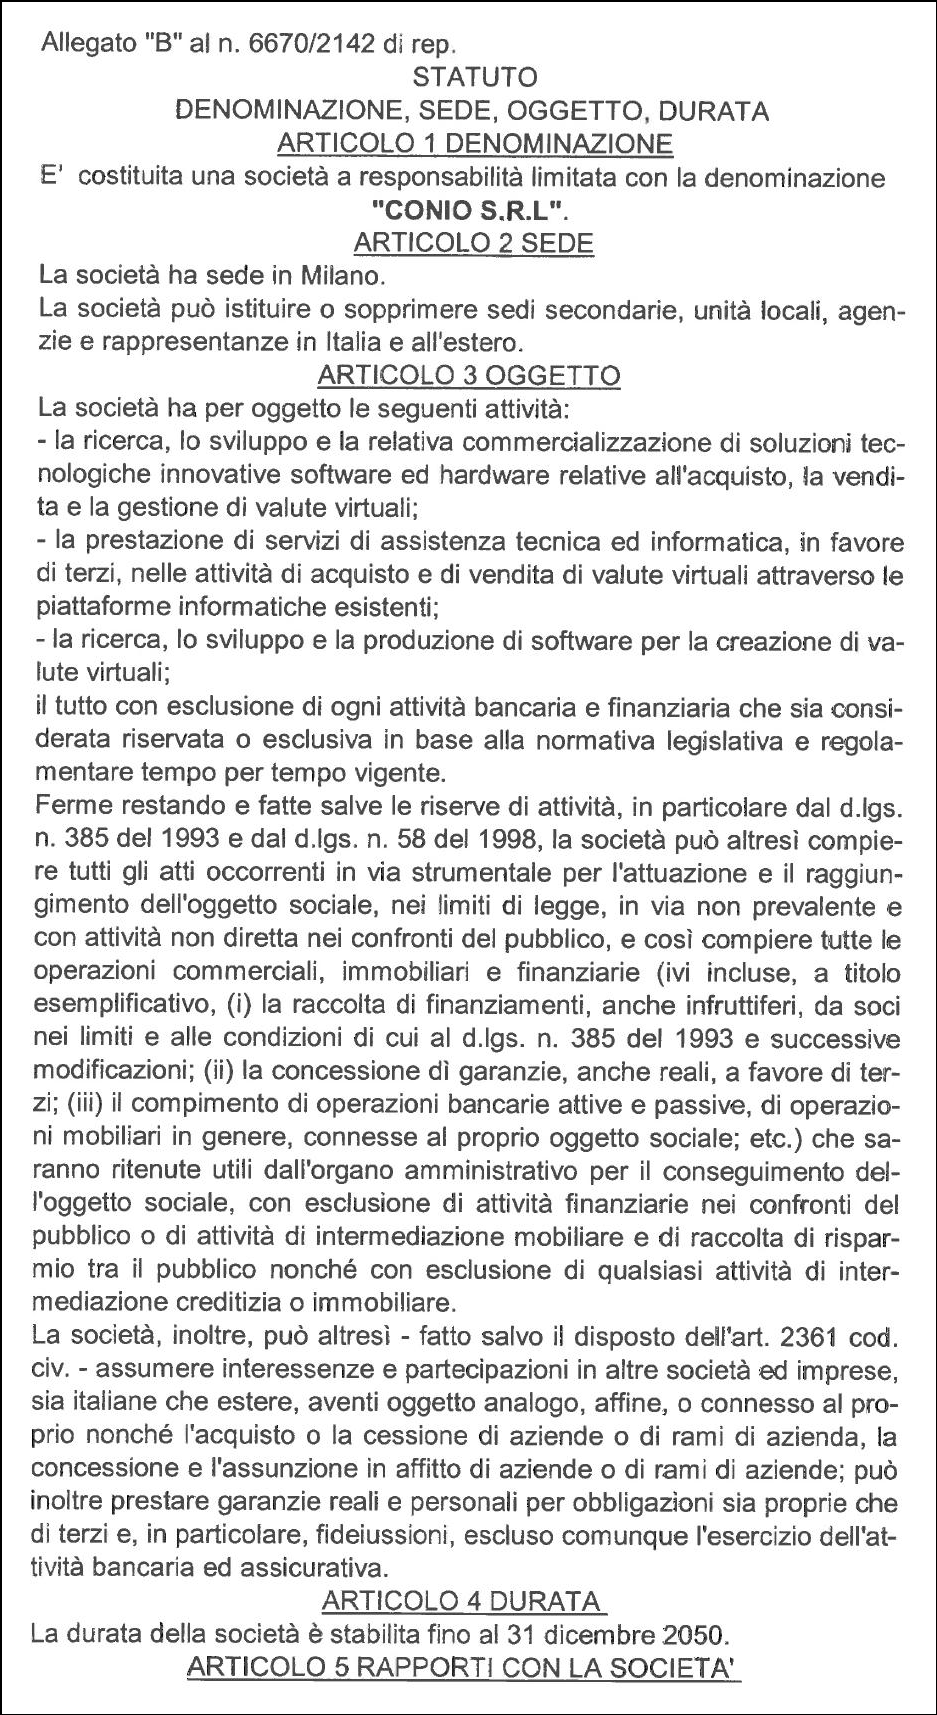

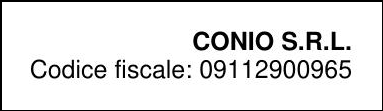

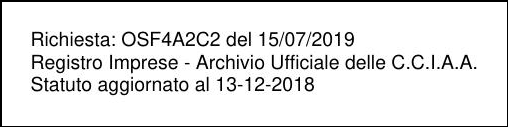

In [92]:
show_multiple_cv2_imgs(roi_regions)